124021.0945235586
124021.09461094317
124021.44358467885
27307.245750704154
27307.037983180955
27307.245750056158
101289.82092295395
101289.82092067708
101289.57640798429
102475.67104150522
102475.67095976835
102475.37310841975
27294.648098975806
27280.463909588692
27294.64809227715
99660.82592792515
99670.956015567
99660.54331610011
27208.162811042137
27097.176212173923
27208.162792189127
56907.489876513144
59236.36029655317
56907.384693781045
27179.60663044959
27036.77904714978
27179.6066103134
27134.37143624067
26941.399015892028
27134.371414409357
20279.564933668662
26753.567207954642
20279.532027408815
27099.489186927407
26868.117451862676
27099.48916436981
15221.773177151355
12623.144354094147
15221.77032701577
12172.08358293794
16406.76284492771
12172.073697868997
12172.08358293794
16406.76284492771
12172.073697868997
27307.24563979265
27307.037751841497
27307.24563914447
25488.281496911164
23661.656479265188
25488.281525334445
14520.725673816272
13255.998499080646
14520.72219382

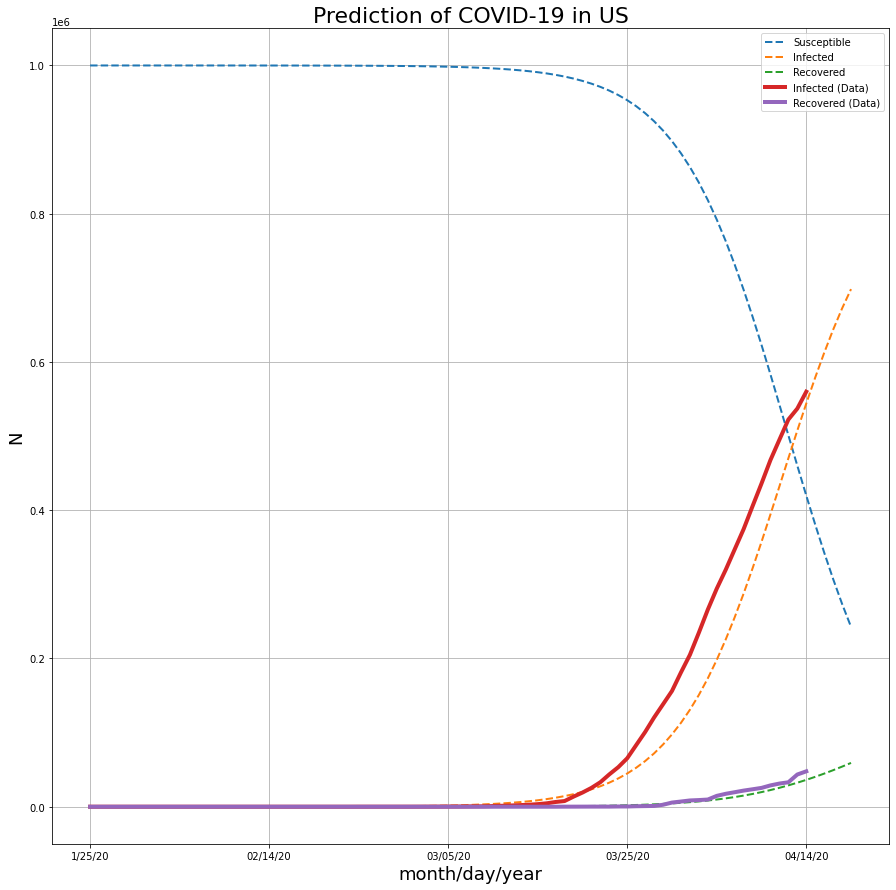

1/25/20         12.000000
01/26/20        12.381444
01/27/20        12.832627
01/28/20        13.366502
01/29/20        13.997465
                ...      
04/15/20    619406.050842
04/16/20    657045.679855
04/17/20    692784.052941
04/18/20    726317.997758
04/19/20    757395.286578
Length: 86, dtype: float64


In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Predict function
def predict(x, infected_data, recovered_data, init, beta, gamma, start, country):
    
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]
        
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
    
    # Extending N days after now
    t_extend = len(x) +5 # N days
    t = np.linspace(0, t_extend, t_extend) #0 + number of dates in data + extended date 
    
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, t_extend], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,t_extend,1))
    
    # Preparing date axis
    date_format = '%m/%d/%y'
    time = start
    for i in range(t_extend-1):
        time_add = datetime.strptime(start, date_format) + timedelta(days=i+1)
        time = np.append(time, time_add.strftime(date_format))
    
    # Adding NaN values of to official data for plotting
    infected_data = np.concatenate((infected_data, [None] * (t_extend-len(infected_data))))
    recovered_data = np.concatenate((recovered_data, [None] * (t_extend-len(recovered_data))))
    
    # Plotting
    df = pd.DataFrame({'Susceptible': res.y[0], 
                        'Infected': res.y[1], 
                        'Recovered': res.y[2], 
                        "Infected (Data)": infected_data, 
                        "Recovered (Data)": recovered_data}, 
                        index=time)
    fig, ax = plt.subplots(figsize = (15,15))
    df['Susceptible'].plot(linestyle = '--', linewidth = 2)
    df['Infected'].plot(linestyle = '--', linewidth = 2)
    df['Recovered'].plot(linestyle = '--', linewidth = 2)
    df['Infected (Data)'].plot(linewidth = 4)
    df['Recovered (Data)'].plot(linewidth = 4)
    plt.ylabel("N", fontsize=18)
    plt.xlabel("month/day/year", fontsize=18)
    plot_title = ('Prediction of COVID-19 in ' + country)
    plt.title(plot_title, fontsize=22)
    plt.legend()
    plt.grid()
    plt.show()
    print(df['Infected']+df['Recovered'])
    

# Cost function for fitting
def cost(point, infected_data, recovered_data, init):
    
    beta, gamma = point
    
    # ODE Function
    def sir(t, y):
            
        # Outputs
        S = y[0]
        I = y[1]
        R = y[2]   
        return [-beta*I*S, beta*I*S - gamma*I, gamma*I]
   
    # Solving SIR : [solver_ivp] - Solve an initial value problem for a system of ODEs.
    res = solve_ivp(sir, 
                    [0, len(infected_data)], 
                    [init[0], init[1], init[2]],
                    t_eval=np.arange(0,len(infected_data),1))
  
    # Returns RMSE (Root Mean Square Error) for the function
    rmse_infect = np.sqrt(np.mean((res.y[1] - infected_data)**2)) 
    rmse_recoverd = np.sqrt(np.mean((res.y[2] - recovered_data)**2)) 
    
    # Defining weights
    alpha = 0.1
    print(alpha*rmse_infect + (1-alpha)*rmse_recoverd)
    return alpha*rmse_infect + (1-alpha)*rmse_recoverd

plt.close()
c_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
r_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

country = "US" # input country here
start_date = "1/25/20" # input starting date here

# Parsing confirmed/recovered cases from csv
confirmed = c_df[c_df['Country/Region'] == country].iloc[0].loc[start_date:]
recovered = r_df[r_df['Country/Region'] == country].iloc[0].loc[start_date:]

# Truncate last element to fit recovered data
confirmed = confirmed.values 
recovered = recovered.values

# I(t)
infect = confirmed - recovered

# Suceptable
N = 500000*2 #current number of infected * 2.0~ 2.5(R0, Reproductive number of COVID-19)
# Number of infected at t0
I0 = 2
S0 = N-I0
R0 = 10

# S(t) = N - I(t) - R(t)
S = N - confirmed

# Parameters to optimize

#Keep working on boundaries.
optimal = minimize(cost, [0.001, 0.001], args=(infect, recovered, [S0, I0, R0]), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])

# Prints Beta/Gamma
print(optimal.x)

# Prints Gamma/Beta, if S0 > Gamma/Beta -> exponential growth
print("Gamma/Beta: " + str(optimal.x[1]/optimal.x[0]))

# Prints Repoductive Ratio S0*Beta/Gamma.
print("S0*Beta/Gamma: " + str(S0*optimal.x[0]/optimal.x[1]))
print("S0 : " +str(S0))

# Predicting numbers from optimized gamma & beta
t = np.linspace(0,len(infect), len(infect))
predict(np.transpose(t), infect, recovered, [S0, I0, R0], optimal.x[0], optimal.x[1], start_date, country)